<a href="https://colab.research.google.com/github/pandurangpatil/erav4-backpropbay/blob/main/04_ERA_V4_Session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [ ]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.05MB/s]


CODE BLOCK: 5

In [38]:
batch_size = 512

train_kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0, 'pin_memory': True}
test_kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 0, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(train_data, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **test_kwargs)


CODE BLOCK: 6

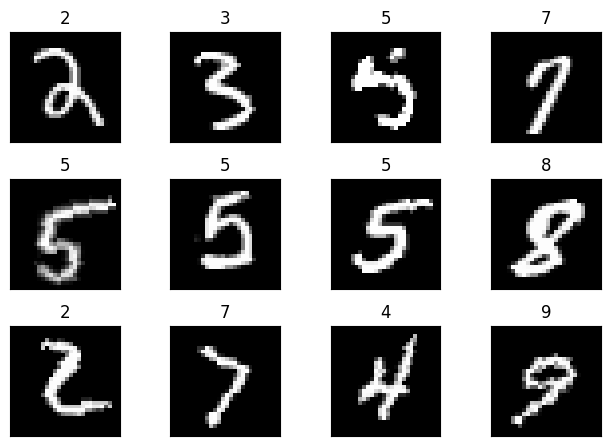

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [45]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        #28X28
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1) # 28X28
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1) # 28X28
        self.fc1 = nn.Linear(8*28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(self.conv2(x), 2)
        x = x.view(-1,8*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [51]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [54]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 5

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  #scheduler.step()

Epoch 1


Train: Loss=0.1297 Batch_id=117 Accuracy=89.50: 100%|██████████| 118/118 [00:23<00:00,  5.06it/s]


Test set: Average loss: 0.0002, Accuracy: 57711/60000 (96.19%)

Epoch 2


Train: Loss=0.2113 Batch_id=117 Accuracy=96.94: 100%|██████████| 118/118 [00:22<00:00,  5.21it/s]


Test set: Average loss: 0.0002, Accuracy: 58485/60000 (97.47%)

Epoch 3


Train: Loss=0.0544 Batch_id=117 Accuracy=97.58: 100%|██████████| 118/118 [00:22<00:00,  5.13it/s]


Test set: Average loss: 0.0002, Accuracy: 58494/60000 (97.49%)

Epoch 4


Train: Loss=0.0891 Batch_id=117 Accuracy=97.81: 100%|██████████| 118/118 [00:23<00:00,  5.09it/s]


Test set: Average loss: 0.0001, Accuracy: 58715/60000 (97.86%)

Epoch 5


Train: Loss=0.0169 Batch_id=117 Accuracy=98.17: 100%|██████████| 118/118 [00:22<00:00,  5.19it/s]


Test set: Average loss: 0.0001, Accuracy: 58987/60000 (98.31%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

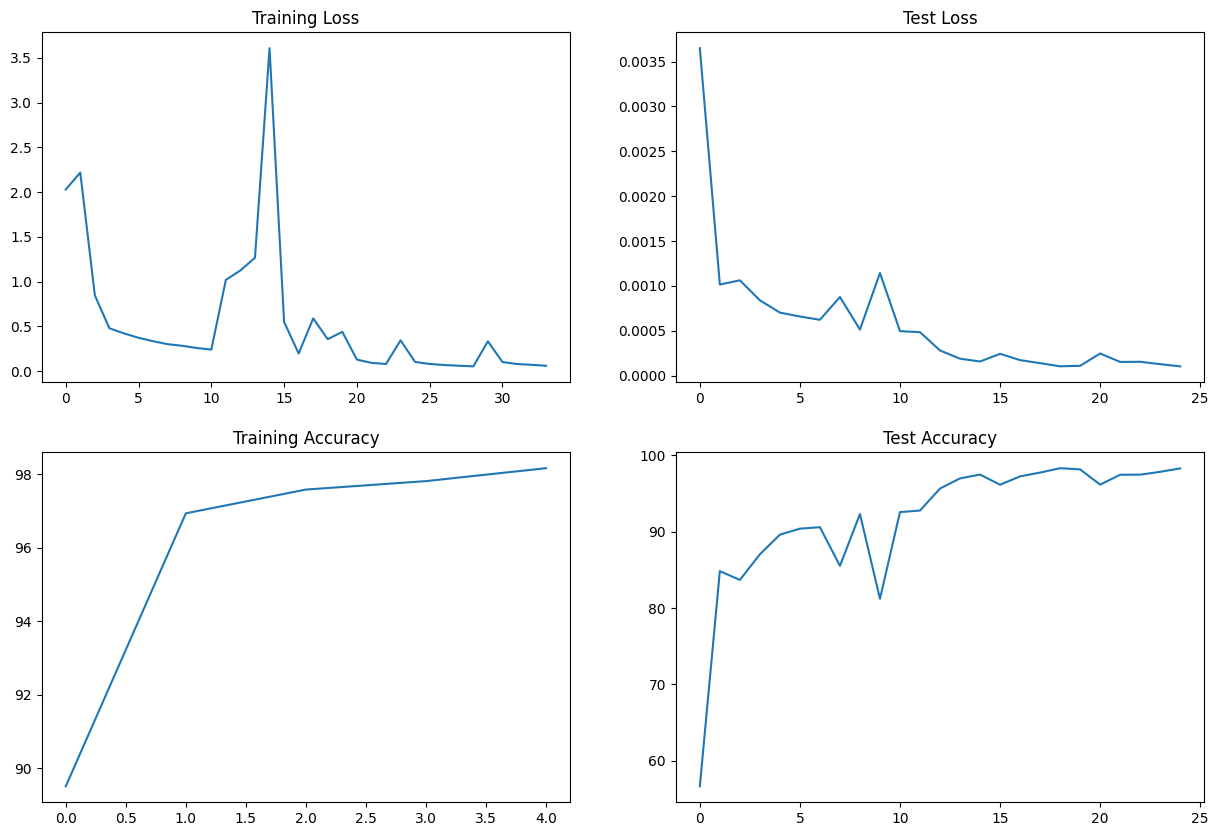

In [56]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [58]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
            Conv2d-2            [-1, 8, 28, 28]             296
            Linear-3                   [-1, 50]         313,650
            Linear-4                   [-1, 10]             510
Total params: 314,496
Trainable params: 314,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.20
Estimated Total Size (MB): 1.27
----------------------------------------------------------------
